In [1]:
# Import libraries
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
# For plot to appear in the notebook
%matplotlib inline 

# Import initial data

In [3]:
# Set the path to the original shapefile - Please adapt the path to your own data
admin1_shape= '/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/Results/Dakar/admin0_aggregation/Dakar_level1.shp'

In [4]:
# Read the shapefile
gdf1 = gpd.read_file(admin1_shape)
# Keep only columns with population data (quantitative) that could be aggregated using a "grouby - sum" function
# Please adapt the column names according to your own data - Be carefull to keep the geometry column
gdf1 = gdf1.loc[:,['geometry','CONCESSION','MENAGE', 'HOMME', 'FEMME', 'POPULATION']]
# Add a column with area (in hectares)
gdf1['area'] = (gdf1.geometry.area/10000).round(4)

In [5]:
# Display the attribute table
gdf1.head()

,geometry,CONCESSION,MENAGE,HOMME,FEMME,POPULATION,area
0,"POLYGON ((250391.4934 1629353.1556, 250319.658...",310,343,1124,1142,2266,10.4294
1,"POLYGON ((250113.2289000005 1629602.2348, 2501...",233,406,1725,1736,3460,15.9978
2,"POLYGON ((249124.5202000001 1630661.2543, 2490...",487,610,1817,1866,3682,43.8812
3,"POLYGON ((249543.9823000003 1630134.403100001,...",139,182,670,678,1348,16.2603
4,"POLYGON ((248771.7659 1630380.8135, 248812.657...",248,365,1348,1272,2620,25.1994


In [12]:
# Print number of units
print "The initial layer contains %s entities."%len(gdf1)

The initial layer contains 677 entities.


In [13]:
# Set style preset parameters from Seaborn 
sns.set_style("darkgrid")
sns.set_context("paper")

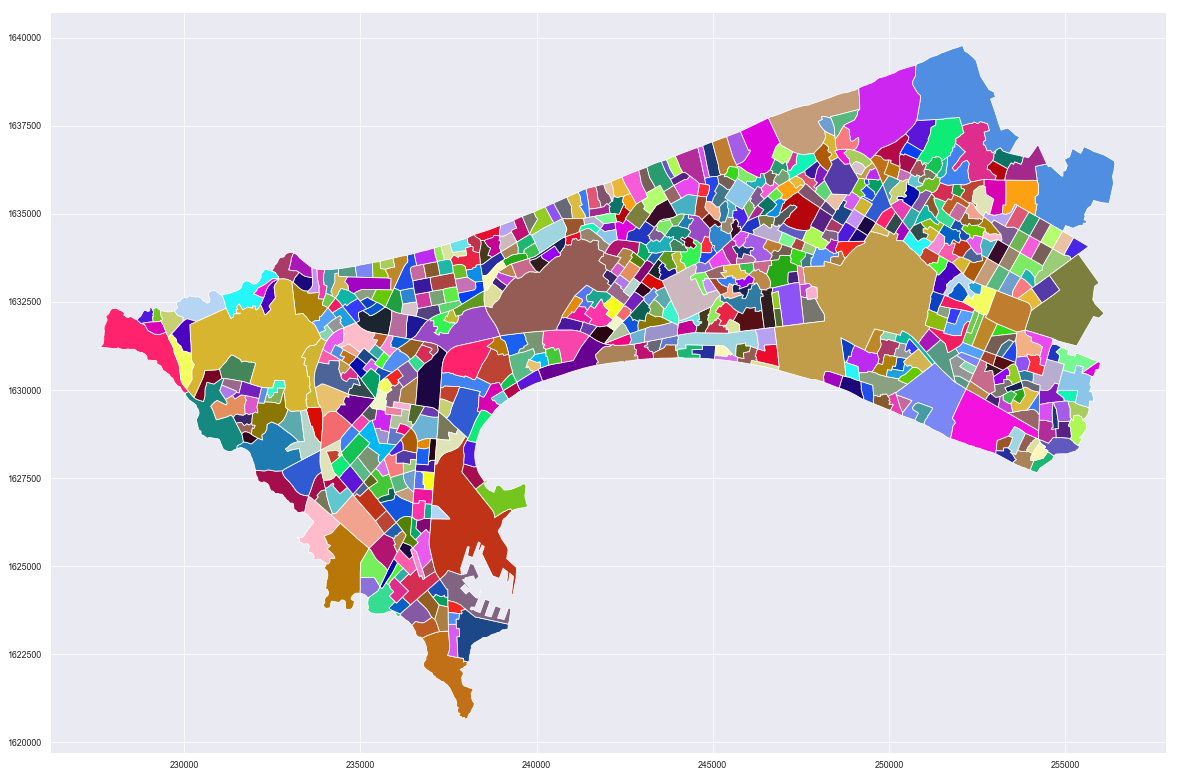

In [14]:
# A random colormap for matplotlib
cmap = mpl.colors.ListedColormap(np.random.rand(256,3))
# Display + Save figure
gdf1.plot(cmap=cmap, figsize=(20,20))
#plt.savefig("Illustrations/original_admin1.png", dpi=300, bbox_inches='tight')

# Kmeans clustering

In [15]:
def add_xy_columns(gdf1):
    # Add two columns to the attribute table with x (long) and y (lat)
    gdf1["x"] = gdf1.centroid.map(lambda p: p.x)
    gdf1["y"] = gdf1.centroid.map(lambda p: p.y)

In [16]:
def kmeans_on_geom_centroid(gdf, n_clusters, n_jobs=3):
# n_clusters : number of desired clusters resulting from the initial Kmeans (int) 
# n_jobs : number of cores (processes) to use for the kmeans (int) 
    if n_clusters < len(gdf):
        # Getting the x/y values
        f1 = gdf['x'].values
        f2 = gdf['y'].values
        X = np.array(list(zip(f1, f2)))
        # Run Kmeans clustering
        kmeans = KMeans(n_clusters=n_clusters, n_jobs=n_jobs).fit(X) 
        labels = kmeans.predict(X) # Getting the cluster labels
        # Joint results to the attribute table
        gdf["cluster"] = labels        
    else:
        print "The desired number of clusters from Kmeans is bigger or equal to the number of initial units.\nPlease reduce the value of 'n_clusters' parameter bellow %s."%(len(gdf)-1)

In [17]:
add_xy_columns(gdf1) # Add XY coordinates of the polygon centroid
kmeans_on_geom_centroid(gdf1, n_clusters=100, n_jobs=15) # Perform Kmeans clustering on XY columns
gdf1.head() # Display the attribute table

,geometry,CONCESSION,MENAGE,HOMME,FEMME,POPULATION,area,x,y,cluster
0,"POLYGON ((250391.4934 1629353.1556, 250319.658...",310,343,1124,1142,2266,10.4294,250415.671612,1.629636e+06,81
1,"POLYGON ((250113.2289000005 1629602.2348, 2501...",233,406,1725,1736,3460,15.9978,249831.998393,1.629669e+06,21
2,"POLYGON ((249124.5202000001 1630661.2543, 2490...",487,610,1817,1866,3682,43.8812,249275.909298,1.630851e+06,84
3,"POLYGON ((249543.9823000003 1630134.403100001,...",139,182,670,678,1348,16.2603,249396.878863,1.629942e+06,21
4,"POLYGON ((248771.7659 1630380.8135, 248812.657...",248,365,1348,1272,2620,25.1994,248949.320700,1.630104e+06,21


# Dissolve admin1 level to get admin0 level

In [18]:
def dissolve_admin1_to_admin0(gdf1):
    # Use dissolve function of Geopandas
    gdf0 = gdf1.dissolve(by='cluster', aggfunc='sum', as_index=False)
    gdf0.drop(['x', 'y'], axis=1, inplace=True) # Drop 'x' and 'y' columns since their sum do not have sense
    # Add count of admin1 unit in each cluster
    count_units = gdf1.dissolve(by='cluster', aggfunc='count', as_index=False)['x']
    gdf0['count'] = count_units
    return gdf0

In [19]:
# Dissolve admin1 level accordint to 'cluster' column to get admin0
gdf0 = dissolve_admin1_to_admin0(gdf1)
# Display the attribute table
gdf0.head()

,cluster,geometry,CONCESSION,MENAGE,HOMME,FEMME,POPULATION,area,count
0,0,"POLYGON ((244912.2615999999 1634584.199200001,...",5434,9774,38807,38722,77532,191.9426,10
1,1,"POLYGON ((237101.4611 1627658.625700001, 23708...",4242,15590,40896,36498,77393,142.7944,10
2,2,"POLYGON ((252555.4655999998 1632195.273800001,...",2063,2867,11603,12644,20738,174.6872,9
3,3,"POLYGON ((236582.3422999997 1632091.1066, 2366...",3361,8854,26702,25727,52430,126.9770,6
4,4,"POLYGON ((251215.5873999996 1635589.1175, 2512...",2017,2860,11488,11517,23000,167.5672,11


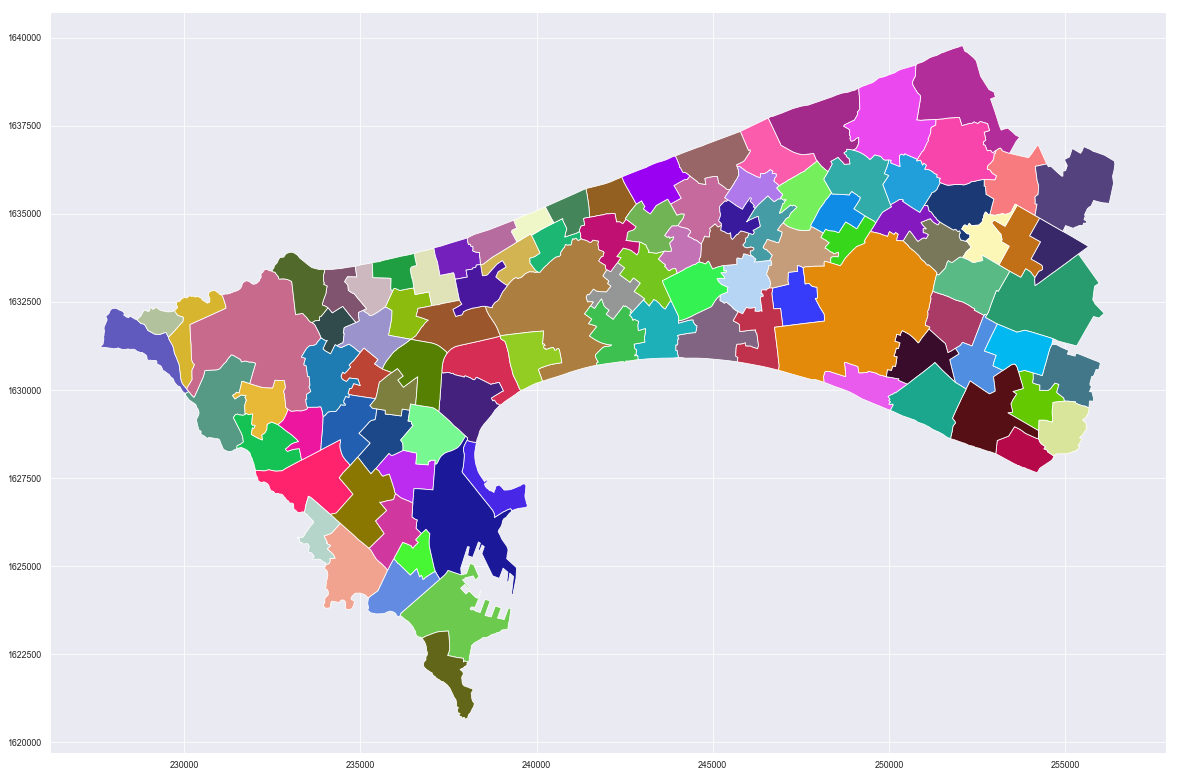

In [20]:
# Display + Save figure
gdf0.plot(column='cluster', cmap=cmap, figsize=(20, 20))
#plt.savefig("Illustrations/admin0_initial_kmeans_results.png", dpi=300, bbox_inches='tight')

# Improve the initial clustering

## Check if cluster members are disjoint from each other

In [21]:
def fix_disjoint_(gdf):
    ## Create a list of unique cluster values (sorted)
    cluster_list = list(gdf.cluster)
    cluster_list.sort()
    cluster_list = list(set(cluster_list)) # Use 'set' to get unique values

    ## Iterate through cluster list 
    found = False
    for cluster in cluster_list:
        a=gdf.loc[gdf1["cluster"]==cluster] # Create a temporary dataframe with units belong to the current cluster
        if len(a) > 1:  # Only continue if there are at least 2 rows in the dataframe
            for index, row in a.iterrows():
                geom_a = row.geometry  # Geometry of the current unit
                other_geom = a[~a.index.isin([index])].geometry # Geometry of the other units belonging to the cluster
                disconected_unit = other_geom.disjoint(geom_a).all() # Return True if all element of the pandas serie are True (all disconect)
                if disconected_unit:
                    found = True
                    new_cluster = gdf.cluster.max()+1
                    gdf.at[index, "cluster"] = new_cluster   # Assign new cluster value
                    print "Cluster %s had one unit disconected from the others that has been assign to new cluster (%s)"%(row.cluster,new_cluster)
    if not found:
        print "No problem found regarding to disjoint cluster members."

In [22]:
## Check and fix for issue of disjointed cluster members in the initial Kmeans results
fix_disjoint_(gdf1)

No problem found regarding to disjoint cluster members.


## Fix issues of clusters compouned by 1 unit only

The strategy implemented here is to merge 1unit-clusters with its neighboring cluster that is compouned by the smallest number of iriginal administratives units.

In [23]:
# Declare a function that check how many cluster are composed of only have one unit 
def check_remaining_single_cluster(df):
    global count_dict
    count_dict={x.cluster:x['count'] for i,x in df.iterrows()}
    number_single_cluster = len(df.loc[df['count']<2])
    return number_single_cluster

In [24]:
# Declare a function that add a "NEIGHBORS" column with id of neighboring clusters 
def find_neighbors(gdf, unique_id="cluster"):
    gdf["NEIGHBORS"] = None  # Add empty NEIGHBORS column
    for index, unit in gdf.iterrows():   
        # get 'not disjoint' countries
        neighbors = gdf[~gdf.geometry.disjoint(unit.geometry)][unique_id].tolist()
        if len(neighbors)==1:
            # Get the geom of the centroid of origin (the current row) and of the destination (all the other points)
            origin_geom = gdf0.iloc[index].geometry.centroid
            destin_geom = gdf0[~gdf0.index.isin([index])].geometry.centroid
            tmp_df = pd.DataFrame(gdf0.loc[:,"cluster"])
            dist_min = pd.DataFrame(destin_geom.geometry.distance(origin_geom))
            tmp_df['dist']=dist_min
            nearest_cluster = int(tmp_df.loc[tmp_df['dist']==float(tmp_df['dist'].min())]['cluster'])
            neighbors = [nearest_cluster]
        # remove own name from the list
        neighbors = [str(Id) for Id in neighbors if unit[unique_id] != Id]
        # add names of neighbors as NEIGHBORS value
        gdf.at[index, "NEIGHBORS"] = ", ".join(neighbors)

In [25]:
# Declare a function that return the id of the biggest neighborhing cluster (in terms of the number of initial units)
def check_biggest_cluster(_dict, _list):
        neighbor_id=[int(x) for x in _list.split(',')]
        candidate_value=_dict[neighbor_id[0]]
        candidate_id=neighbor_id[0]
        for x in neighbor_id[1:]:
            if _dict[x] > candidate_value:
                candidate_value=_dict[x]
                candidate_id=x
        return candidate_id

In [26]:
# Declare a function that return the id of the smallest neighborhing cluster (in terms of the number of initial units)
def check_smallest_cluster(_dict, _list):
        neighbor_id=[int(x) for x in _list.split(',')]
        candidate_value=_dict[neighbor_id[0]]
        candidate_id=neighbor_id[0]
        for x in neighbor_id[1:]:
            if _dict[x] < candidate_value:
                candidate_value=_dict[x]
                candidate_id=x
        return candidate_id

In [27]:
find_neighbors(gdf0) # Add/update the list of neighbors of each cluster
gdf0.head() # Display the attribute table

,cluster,geometry,CONCESSION,MENAGE,HOMME,FEMME,POPULATION,area,count,NEIGHBORS
0,0,"POLYGON ((244912.2615999999 1634584.199200001,...",5434,9774,38807,38722,77532,191.9426,10,"39, 54, 58, 63, 75, 97, 98"
1,1,"POLYGON ((237101.4611 1627658.625700001, 23708...",4242,15590,40896,36498,77393,142.7944,10,"14, 45, 71, 80, 95"
2,2,"POLYGON ((252555.4655999998 1632195.273800001,...",2063,2867,11603,12644,20738,174.6872,9,"32, 37, 84, 85"
3,3,"POLYGON ((236582.3422999997 1632091.1066, 2366...",3361,8854,26702,25727,52430,126.9770,6,"27, 60, 67, 69, 88, 99"
4,4,"POLYGON ((251215.5873999996 1635589.1175, 2512...",2017,2860,11488,11517,23000,167.5672,11,"20, 46, 49, 52, 86"


In [28]:
## Minimum original units per cluster
# Please adapt this value with the minimum number of original units you desire in the final clusters
# Please consider a reasonable and judicious number, according to the context of your data
min_units = 4

## As long as there remain issues (clusters with only one admin unit) merge it with the neighboring cluster that have the smallest number of admin units
current_number_clusters = len(gdf0)
remaining = check_remaining_single_cluster(gdf0)  # remaining variable takes number of cluster remaining with only 1 original unit
if remaining == 0:
    print "The admin 1 layer contains %s clusters."%current_number_clusters
    print "Nothing to fix: All clusters are compouned by at least %s original administrative units"%min_units
else:
    print "Fixing issue(s)..."
    while remaining > 0:
        for index, unit in gdf0.iterrows():   
            if unit['count'] < min_units:
                list_neighbors=unit.NEIGHBORS
                ## For the next two lines, please comment/uncomment accorind the your prefered way for finding the "best" candidate cluster
                candidate_cluster=check_smallest_cluster(count_dict,list_neighbors)               
                #candidate_cluster=check_biggest_cluster(count_dict,list_neighbors)
                print "   -> cluster %s only have 1 original unit and will be merge with cluster %s"%(unit['cluster'],candidate_cluster)
                # Update the value of 'cluster' column (result of Kmeans) with the new candidate cluster
                gdf1['cluster'] = gdf1.cluster.apply(lambda x: candidate_cluster if x == unit['cluster'] else x)  
                break  # Allow to operate dissolving one by one
        # Dissolve according to the updated cluster membership
        gdf0 = dissolve_admin1_to_admin0(gdf1)
        find_neighbors(gdf0)
        remaining = check_remaining_single_cluster(gdf0)
        print 'remaining issues : %s'%remaining
    current_number_clusters = len(gdf0)
    print "\n**-_-_-_-_-_-_-_-_-_-_-_-_-_-_**"
    print "\nThe admin 1 layer contains %s clusters."%current_number_clusters
    print "\nAll issues have been removed: All clusters are compouned by at least %s original administrative units"%min_units    

Fixing issue(s)...
   -> cluster 22 only have 1 original unit and will be merge with cluster 78
remaining issues : 4
   -> cluster 33 only have 1 original unit and will be merge with cluster 47
remaining issues : 3
   -> cluster 36 only have 1 original unit and will be merge with cluster 56
remaining issues : 3
   -> cluster 48 only have 1 original unit and will be merge with cluster 52
remaining issues : 2
   -> cluster 82 only have 1 original unit and will be merge with cluster 26
remaining issues : 2
   -> cluster 89 only have 1 original unit and will be merge with cluster 61
remaining issues : 2
   -> cluster 91 only have 1 original unit and will be merge with cluster 7
remaining issues : 1
   -> cluster 94 only have 1 original unit and will be merge with cluster 35
remaining issues : 0

**-_-_-_-_-_-_-_-_-_-_-_-_-_-_**

The admin 1 layer contains 92 clusters.

All issues have been removed: All clusters are compouned by at least 4 original administrative units


In [30]:
# Print number of units
print "The resulting layer contains %s entities."%len(gdf0)

The resulting layer contains 92 entities.


## Display final result - Admin 0 borders

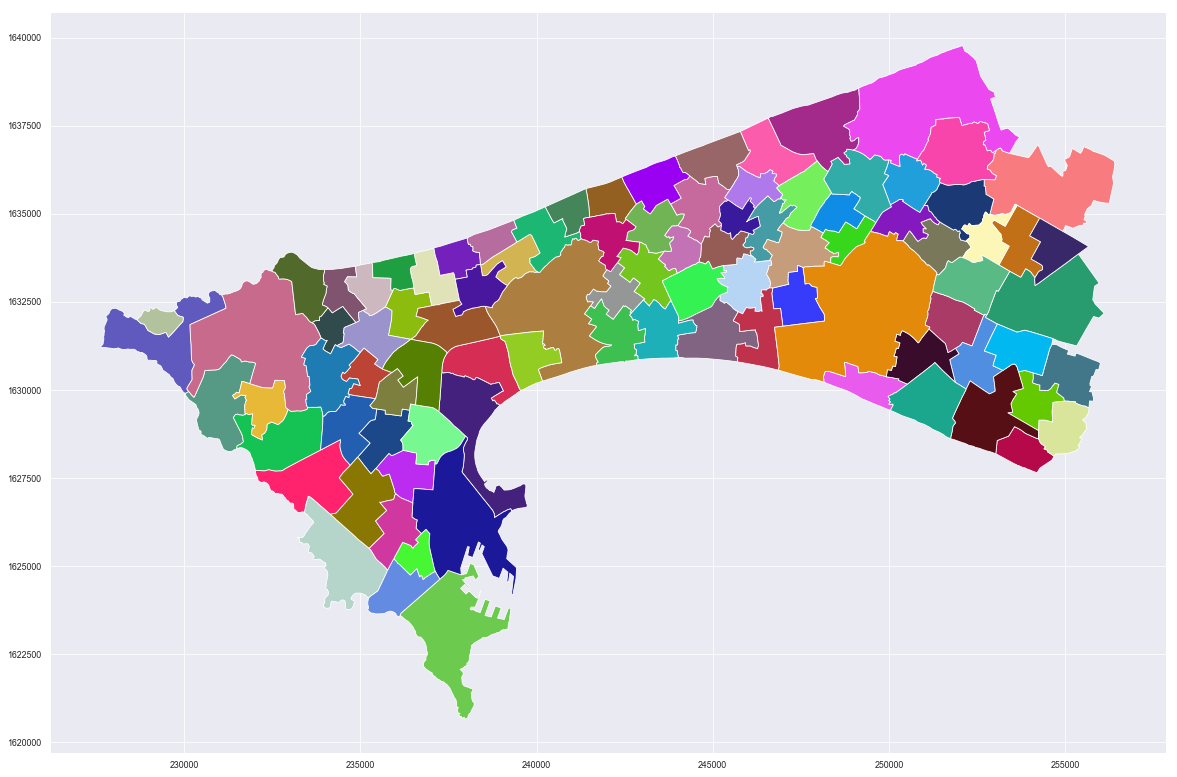

In [31]:
# Display + Save figure
gdf0.plot(column='cluster', cmap=cmap, figsize=(20, 20))
#plt.savefig("Illustrations/newly_created_admin0.png", dpi=300, bbox_inches='tight')

# Export admin0 shapefile

In [32]:
# Set the path to the shapefile to be created
shape_export = '/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/Results/Dakar/admin0_aggregation/Dakar_level0.shp'
# Export
gdf0.to_file(driver='ESRI Shapefile',filename=shape_export)

# Plot distribution of number of initial units per cluster

In [33]:
# Get a list with count values
x = list(gdf0['count'])

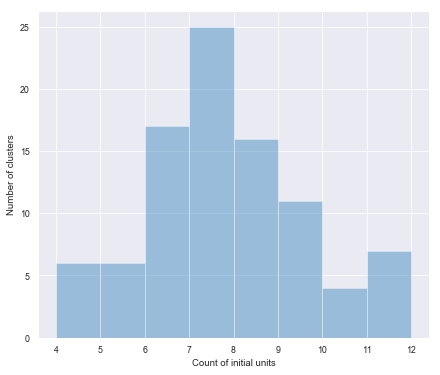

In [52]:
# Plot the distribution
#nbins=max(x)-min_units
plt.figure(figsize=(7,6))
#plt.title('Number of original unit',fontdict={'fontsize': 15})
plt.ylabel ("Number of clusters")
plt.xlabel("Count of initial units")
sns.set_style("darkgrid")
sns.set_context("paper")
sns.distplot(x, bins=8, kde=False)
#sns.distplot(x, bins=nbins, kde=False)
plt.savefig("/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/Results/Dakar/admin0_aggregation/Clustering_distribution.png",
            dpi=300, bbox_inches='tight')
plt.savefig("/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/Results/Dakar/admin0_aggregation/Clustering_distribution.eps",
            dpi=300, bbox_inches='tight')

# Get basic descriptive statistics

In [39]:
# Get basic descritpitve statistics of units
def get_basic_stats(gdf1, gdf0):
    df = pd.DataFrame()
    df[''] = ['Number of units', 'Median area (ha.)', 'Minimum population density (inhab./ha.)', 
              'Median population density (inhab./ha.)', 'Maximum population density (inhab./ha.)'] 
    df['Level 1'] = [int(len(gdf1)), 
                     round((gdf1.geometry.area/10000).median(),2),
                     round((gdf1.POPULATION/(gdf1.geometry.area/10000)).min(),2),
                     round((gdf1.POPULATION/(gdf1.geometry.area/10000)).median(),2),
                     round((gdf1.POPULATION/(gdf1.geometry.area/10000)).max(),2)]
    df['Level 0'] = [int(len(gdf0)), 
                     round((gdf0.geometry.area/10000).median(),2),
                     round((gdf0.POPULATION/(gdf0.geometry.area/10000)).min(),2),
                     round((gdf0.POPULATION/(gdf0.geometry.area/10000)).median(),2),
                     round((gdf0.POPULATION/(gdf0.geometry.area/10000)).max(),2)]
    return df

In [43]:
# Get table with basic statistics
stat_table = get_basic_stats(gdf1, gdf0)
stat_table

,,Level 1,Level 0
0,Number of units,677.00,92.00
1,Median area (ha.),16.49,167.42
2,Minimum population density (inhab./ha.),0.81,5.89
3,Median population density (inhab./ha.),184.59,164.04
4,Maximum population density (inhab./ha.),1047.23,541.99


In [50]:
# Export the table
stat_table.to_csv("/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/Results/Dakar/admin0_aggregation/Aggregation_basic_stats.csv")